# 의사결정트리 (Titanic)

## #01. 패키지

In [51]:
import re   # 정규표현식 연산 패키지
import numpy as np
import seaborn as sb

from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import dtreeviz

## #02. 데이터

csv 파일 읽기

In [2]:
train = read_csv('data/titanic/train.csv')
test = read_csv('data/titanic/test.csv')

print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### DF 원본 백업

In [3]:
original_train = train.copy()
original_test = test.copy()

### train/test 데이터 병합

In [4]:
full_data = [train, test]
print(type(full_data))
full_data   # multi Series 형태

<class 'list'>


[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

## #03. 데이터 전처리

In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 객실 유무

In [6]:
train['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [7]:
train['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)
test['Has_Cabin'] = train['Cabin'].apply(lambda x:0 if type(x)==float else 1)

### 가족 구성원 수

In [8]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + train['Parch'] + 1

### 혼자 탑승했는지 여부

In [9]:
train["ISAlone"] = 0
train.loc[train['FamilySize']==1, "ISAlone"] = 1   # index 접근(loc)

test["ISAlone"] = 0
test.loc[train['FamilySize']==1, "ISAlone"] = 1   # index 접근(loc)

### 탑승지 결측치 처리

소수의 결측치 데이터(train 기준 2건)을 최빈값으로 대체

In [10]:
# 임시코드
train['Embarked'].value_counts()
train['Embarked'].isna().sum()

2

In [11]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')
print(train['Embarked'].isna().sum())
print(test['Embarked'].isna().sum())

0
0


### 요금 데이터 결측치 확인/처리

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin',
       'FamilySize', 'ISAlone'],
      dtype='object')

In [13]:
train['Fare'].isna().sum()

0

In [14]:
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

### 나이 데이터의 결측치 처리

#### 훈련데이터

In [15]:
age_avg = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
# 평균 값을 중심으로 표준 편차 범위 내에서 랜덤한 정수값을 age_null_count 길이 만큼 생성
age_null_rnd_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)

# 결측치에 해당하는 행에 랜덤값을 채워준다
# np.isnan(train['Age']) # null 값 index 정보
train.loc[np.isnan(train['Age']), 'Age'] = age_null_rnd_list

train['Age'] = train['Age'].astype(int)

#### 검증 데이터

In [16]:
age_avg = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
age_null_rnd_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)

# 결측치에 해당하는 행에 랜덤값을 채워준다
# np.isnan(train['Age']) # null 값 index 정보
test.loc[np.isnan(test['Age']), 'Age'] = age_null_rnd_list

test['Age'] = test['Age'].astype(int)

### 정규표현식 처리 함수

이름에서 알파벳을 제외한 나머지 글자를 제외하고 어절 단위로 리스트로 묶은 후 인덱스가 1인 위치를 리턴하는 함수

In [17]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ""

In [18]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin',
       'FamilySize', 'ISAlone'],
      dtype='object')

In [19]:
train["Title"] = train["Name"].apply(get_title)
# print(train['Title'].value_counts())
print(list(train['Title'].value_counts().index))

['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']


In [20]:
train['Title'] = train['Title'].replace(['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")

In [21]:
print(list(train['Title'].value_counts().index))

['Mr', 'Miss', 'Mrs', 'Master', 'Rare']


In [22]:
test["Title"] = train["Name"].apply(get_title)
# print(test['Title'].value_counts())
print(list(test['Title'].value_counts().index))
test['Title'] = test['Title'].replace(['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")
print(list(test['Title'].value_counts().index))

['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Dr', 'Don', 'Mme']
['Mr', 'Miss', 'Mrs', 'Master', 'Rare']


### 데이터 라벨링

#### 성별

In [23]:
train['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [24]:
train['Sex'] = train['Sex'].map({"female":0, "male":1})
test['Sex'] = test['Sex'].map({"female":0, "male":1})

In [25]:
train['Sex'].value_counts()

Sex
1    577
0    314
Name: count, dtype: int64

#### 호칭

In [26]:
train['Title'].value_counts()

Title
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

In [27]:
train['Title'] = train["Title"].map({'Mr':1, 'Master':2, 'Mrs':3, 'Miss':4, "Rare":5})
test['Title'] = test["Title"].map({'Mr':1, 'Master':2, 'Mrs':3, 'Miss':4, "Rare":5})

In [28]:
train['Title'].value_counts()

Title
1    517
4    182
3    125
2     40
5     27
Name: count, dtype: int64

#### 탑승지

In [29]:
test['Embarked'].value_counts()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

In [30]:
test['Embarked'] = test['Embarked'].map({"S":0, "C":1, "Q":2})
train['Embarked'] = train['Embarked'].map({"S":0, "C":1, "Q":2})

In [31]:
test['Embarked'].value_counts()

Embarked
0    270
1    102
2     46
Name: count, dtype: int64

In [32]:
train['Embarked'].value_counts()

Embarked
0    646
1    168
2     77
Name: count, dtype: int64

> 분류모델은 라벨링한 상태에서 결과가 더 좋음

#### 연령대 분할

청소년기 16살을 기준으로 나이 데이터를 분할

In [33]:
# numpy where로도 같은 효과 도출
train.loc[train['Age'] <= 16, "Age"] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 32), "Age"] = 1
train.loc[(train['Age'] > 32) & (train['Age'] <= 48), "Age"] = 2
train.loc[(train['Age'] > 48) & (train['Age'] <= 64), "Age"] = 3
train.loc[train['Age'] > 64, "Age"] = 4

test.loc[train['Age'] <= 16, "Age"] = 0
test.loc[(test['Age'] > 16) & (test['Age'] <= 32), "Age"] = 1
test.loc[(test['Age'] > 32) & (test['Age'] <= 48), "Age"] = 2
test.loc[(test['Age'] > 48) & (test['Age'] <= 64), "Age"] = 3
test.loc[test['Age'] > 64, "Age"] = 4

#### 탑승 요금 분할

탑승 요금의 최대/최소, 사분위 수 확인

In [34]:
train['Fare'].quantile([0, 0.25, 0.5, 0.75, 1.0])

0.00      0.0000
0.25      7.9104
0.50     14.4542
0.75     31.0000
1.00    512.3292
Name: Fare, dtype: float64

In [35]:
train.loc[train['Fare'] >= 7.91, "Fare"] = 0
train.loc[(train['Age'] > 7.91) & (train['Fare'] <= 14.45), "Age"] = 1
train.loc[(train['Age'] > 14.45) & (train['Fare'] <= 31), "Age"] = 2
train.loc[train['Age'] > 31, "Fare"] = 3

test.loc[test['Fare'] >= 7.91, "Fare"] = 0
test.loc[(test['Age'] > 7.91) & (test['Fare'] <= 14.45), "Age"] = 1
test.loc[(test['Age'] > 14.45) & (test['Fare'] <= 31), "Age"] = 2
test.loc[test['Age'] > 31, "Fare"] = 3

### 불필요한 필드 제거

In [36]:
original_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [37]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [38]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,0,3,1,1,0,7.25,0,0,2,0,1
1,1,1,0,2,0,0.00,1,1,2,0,3
2,1,3,0,1,0,0.00,0,0,1,1,4
3,1,1,0,2,0,0.00,0,1,2,0,3
4,0,3,1,2,0,0.00,0,0,1,1,1


In [39]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,3,1,0,0,7.8292,2,0,1.0,0,1
1,3,0,0,0,7.0000,0,1,2.0,0,3
2,2,1,0,0,0.0000,2,0,1.0,1,4
3,3,1,0,0,0.0000,0,1,1.0,0,3
4,3,0,0,1,0.0000,0,0,2.0,1,1


### 전처리 결과 확인

상관관계 분석

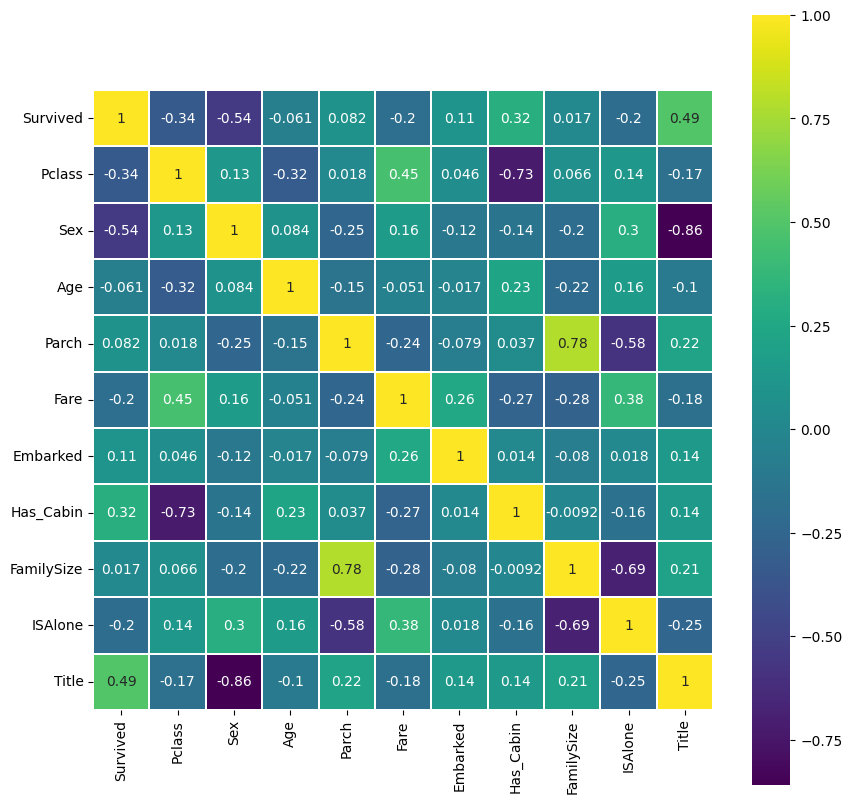

In [40]:
plt.figure(figsize=(10,10))
sb.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,
           cmap=plt.cm.viridis, linecolor='white', annot=True)
plt.show()
plt.close()

### 선정된 최종 변수

성별과 나이의 경우 Title에 대한 상관계수가 지나치게 높기 때문에 Title과 함께 사용하는 것은 적절하지 않다고 판단

In [41]:
x_train = train.drop(['Sex', 'Age', 'Survived'], axis=1)
y_train = train['Survived']

## #04. 의사결정 트리 

### 최적의 파라미터 찾기

In [44]:
dtree = DecisionTreeClassifier(random_state=777)

# dictionary 형태
params = {
    'max_depth':[3,5,7,9],  # decisiontree 깊이
    'min_samples_split':[2,3,4],    # 노드를 분할하는데 필요한 최소 샘플 수
    'splitter':['best', 'random']   # 각 노드에서 분할을 선택하는데 사용되는 전략
}

grid_dt = GridSearchCV(dtree, param_grid=params, cv=5, n_jobs=-1)

grid_dt.fit(x_train, y_train)    # 학습
print(grid_dt.best_params_, grid_dt.best_score_)

# 아래의 과정을 통해 최적의 모델을 추출
result = DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

{'max_depth': 5, 'min_samples_split': 2, 'splitter': 'best'} 0.8271608813006088


,max_depth,min_samples_split,splitter,mean_test_score
6,5,2,best,0.827161
8,5,3,best,0.827161
10,5,4,best,0.827161
7,5,2,random,0.826044
9,5,3,random,0.826044
11,5,4,random,0.826044
0,3,2,best,0.823759
2,3,3,best,0.823759
4,3,4,best,0.823759
20,9,3,best,0.814852


### 검증 데이터를 훈련 데이터화 동일하게 필터링

In [46]:
test_df = test.filter(x_train.columns)
test_df

,Pclass,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,3,0,7.8292,2,0,1.0,0,1
1,3,0,7.0000,0,1,2.0,0,3
2,2,0,0.0000,2,0,1.0,1,4
3,3,0,0.0000,0,1,1.0,0,3
4,3,1,0.0000,0,0,2.0,1,1
...,...,...,...,...,...,...,...,...
413,3,0,0.0000,0,0,1.0,1,1
414,1,0,0.0000,1,0,1.0,1,1
415,3,0,7.2500,0,0,1.0,1,3
416,3,0,0.0000,0,0,2.0,0,3


### 최종 모델

In [49]:
dtree = DecisionTreeClassifier(
    random_state=777,
    max_depth=grid_dt.best_params_['max_depth'],
    min_samples_split=grid_dt.best_params_['min_samples_split'],
    splitter=grid_dt.best_params_['splitter'])

dtree.fit(x_train, y_train) # 학습
y_pred = dtree.predict(test_df) #예측
print(dtree.score(x_train, y_train))
y_pred[:5]

0.8383838383838383


array([0, 0, 1, 0, 0], dtype=int64)

### 결과 시각화

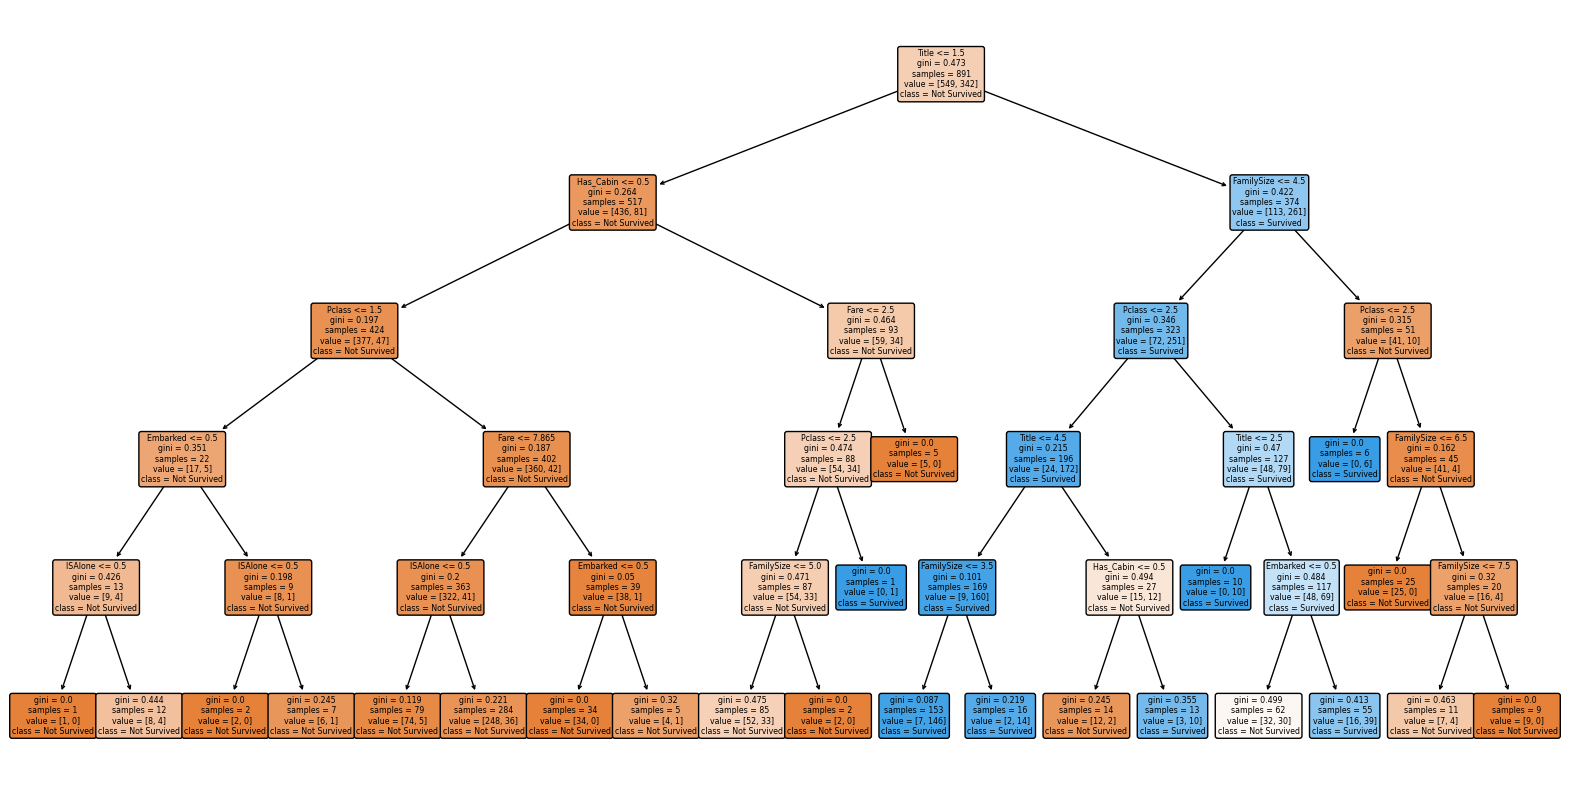

In [54]:
plt.figure(figsize=(20, 10))

# 리턴을 안받으면 그래프가 2개 출력된다. 리턴값을 따로 사용할 것이 아니므로 언더바로 받는다.
_ = plot_tree(
    dtree,
    feature_names=list(x_train.columns),
    class_names=['Not Survived', 'Survived'],
    rounded=True,   # 노드의 모서리를 둥글게
    filled=True  # 노드의 색상을 다르게
    )
plt.show()
plt.close()

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


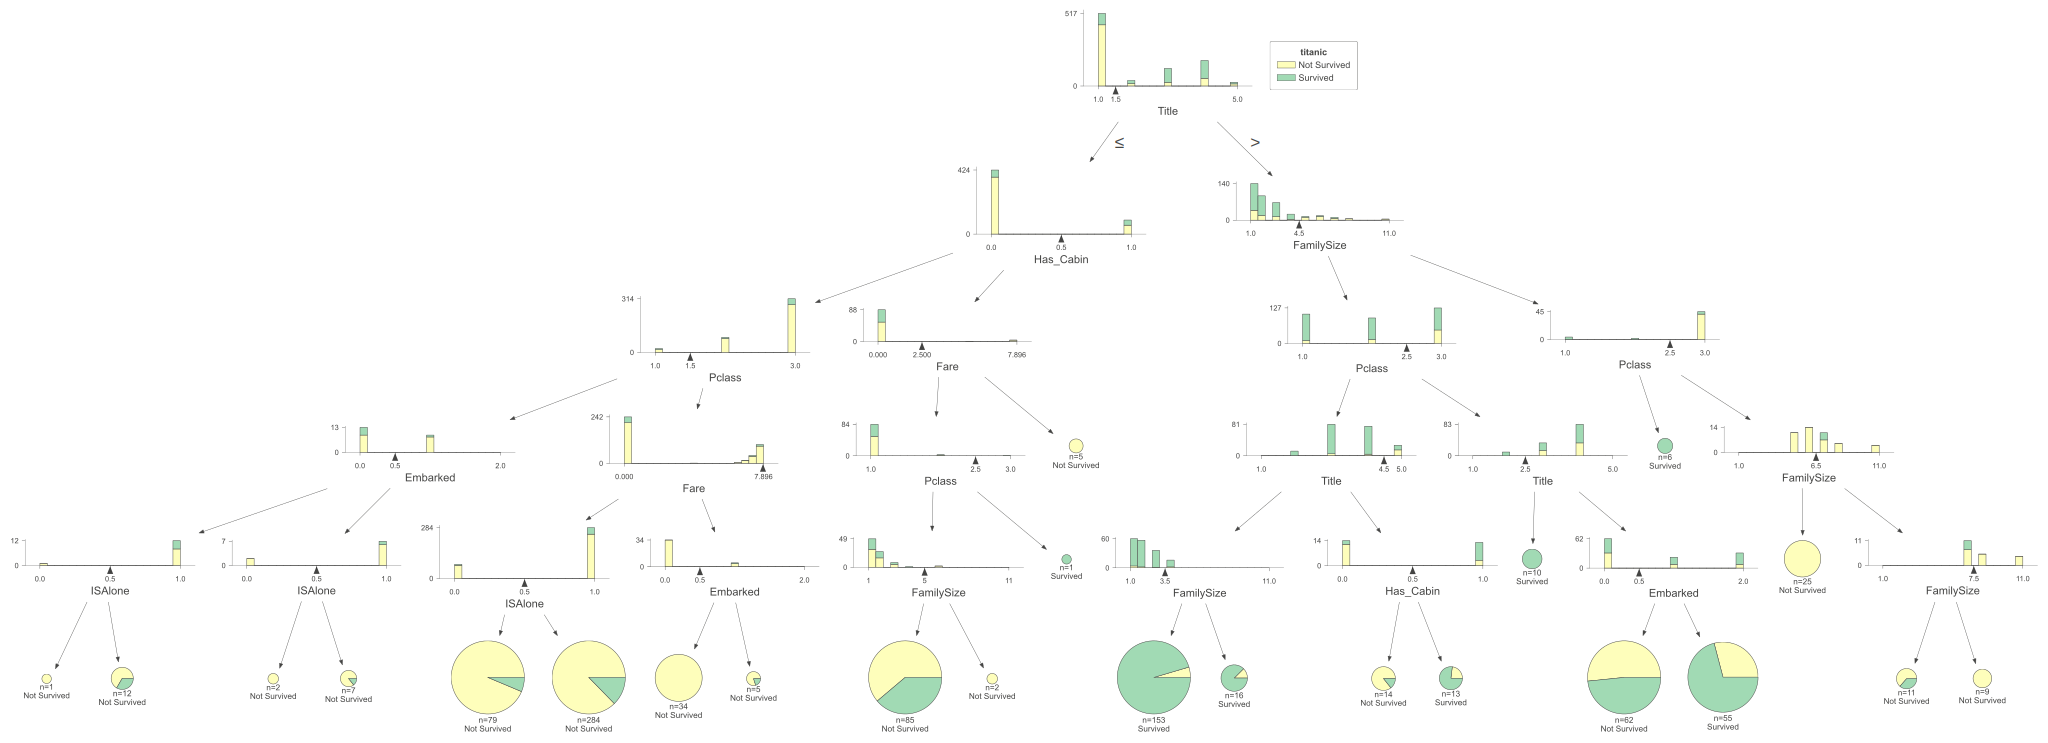

In [55]:
viz = dtreeviz.model(
    dtree,
    X_train=x_train,
    y_train=y_train,
    target_name='titanic',
    feature_names=x_train.columns,
    class_names=['Not Survived', 'Survived']
)
viz.view(scale=2.0)